In [ ]:
# default_exp detectron2_detector

# detect

> Pose Detector class based on Detectron2 and some pose modification tools

In [ ]:
#hide
from nbdev.showdoc import *

In [1]:
#hide
%pip install pyyaml

# Install the latest version of PyTorch availale for your machine

import torch
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
# Install detectron2 that matches the above pytorch version
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
#%pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/$CUDA_VERSION/torch$TORCH_VERSION/index.html
# If there is not yet a detectron2 release that matches the given torch + CUDA version, you need to install a different pytorch.
# Or build it from source
%pip install 'git+https://github.com/facebookresearch/detectron2.git'

# Install DensePose project, allows it to be imported as densepose
%pip install git+https://github.com/facebookresearch/detectron2@main#subdirectory=projects/DensePose

%pip install wget
import wget
wget.download("https://raw.githubusercontent.com/facebookresearch/detectron2/main/projects/DensePose/configs/densepose_rcnn_R_50_FPN_s1x.yaml")
wget.download("https://raw.githubusercontent.com/facebookresearch/detectron2/main/projects/DensePose/configs/Base-DensePose-RCNN-FPN.yaml")

# exit(0)  # After installation, you may need to restart the runtime

Note: you may need to restart the kernel to use updated packages.
torch:  1.10 ; cuda:  1.10.0
  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-61wyj9s2
  Running command git clone -q https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-61wyj9s2
  Using cached pycocotools-2.0.2.tar.gz (23 kB)
  Using cached yacs-0.1.8-py3-none-any.whl (14 kB)
  Using cached tabulate-0.8.9-py3-none-any.whl (25 kB)
  Using cached cloudpickle-2.0.0-py3-none-any.whl (25 kB)
  Using cached fvcore-0.1.5.post20211023.tar.gz (49 kB)
  Using cached iopath-0.1.9-py3-none-any.whl (27 kB)
     |████████████████████████████████| 74 kB 4.1 MB/s  eta 0:00:01
     |████████████████████████████████| 145 kB 107.7 MB/s eta 0:00:01
     |████████████████████████████████| 130 kB 119.4 MB/s eta 0:00:01
     |████████████████████████████████| 112 kB 114.1 MB/s eta 0:00:01
  Using cached mypy_extensions-0.4.3-py2.py3-none-any.whl (4.5 kB)
     |███████████████████████████████

  Created wheel for detectron2: filename=detectron2-0.6-cp37-cp37m-linux_x86_64.whl size=5923411 sha256=bf48266d97b59dfd9cfdde5f47b5a239153230a586c6805b5dcc2f51a05fb1c3
  Stored in directory: /tmp/pip-ephem-wheel-cache-ab0a2mxg/wheels/07/dc/32/0322cb484dbefab8b9366bfedbaff5060ac7d149d69c27ca5d
  Created wheel for pycocotools: filename=pycocotools-2.0.2-cp37-cp37m-linux_x86_64.whl size=272441 sha256=a12402303d510f59f12e9ee73f566142f6814f667ea57d8138935e788d1886ec
  Stored in directory: /home/broadwell/.cache/pip/wheels/bc/cf/1b/e95c99c5f9d1648be3f500ca55e7ce55f24818b0f48336adaf
  Created wheel for fvcore: filename=fvcore-0.1.5.post20211023-py3-none-any.whl size=60947 sha256=90afd16c62a9148756136fbc593d8201374f95d18b4638c269e43d30e31e1b80
  Stored in directory: /home/broadwell/.cache/pip/wheels/16/98/fc/252d62cab6263c719120e06b28f3378af59b52ce7a20e81852
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-py3-none-any.whl size=141230 sha256=1cdfb303eaa67f6b115a

In [1]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

import densepose

from densepose.vis.extractor import (
    CompoundExtractor,
    DensePoseOutputsExtractor,
    DensePoseResultExtractor,
    create_extractor,
)
from densepose.vis.base import CompoundVisualizer
from densepose.vis.bounding_box import ScoredBoundingBoxVisualizer
from densepose.vis.densepose_outputs_vertex import (
    DensePoseOutputsTextureVisualizer,
    DensePoseOutputsVertexVisualizer,
    get_texture_atlases,
)
from densepose.vis.densepose_results import (
    DensePoseResultsContourVisualizer,
    DensePoseResultsFineSegmentationVisualizer,
    DensePoseResultsUVisualizer,
    DensePoseResultsVVisualizer,
)
from densepose.vis.densepose_results_textures import (
    DensePoseResultsVisualizerWithTexture,
    get_texture_atlas,
)

/home/broadwell/anaconda3/envs/torch/lib/python3.7/site-packages/densepose/vis/densepose_results.py:311: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/home/broadwell/anaconda3/envs/torch/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/broadwell/anaconda3/envs/torch/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/broadwell/.local/lib/python3.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/broadwell/.local/lib/python3.7/site-packages/traitlets/config/application.py", line 664, in launch_instance
    app.start()
  File "/home/broadwell/.local/lib/python3.7/si

In [29]:
import matplotlib.pyplot as plt

def just_image(ima):
    w,h = plt.figaspect(ima)
    fig, ax = plt.subplots(figsize=(w*2, h*2), dpi=72)
    fig.subplots_adjust(0,0,1,1)
    plt.axis('off')
    ax.imshow(ima)
    plt.show()

In [11]:
from PIL import Image
im = cv2.imread("sample_data/sample1.png")

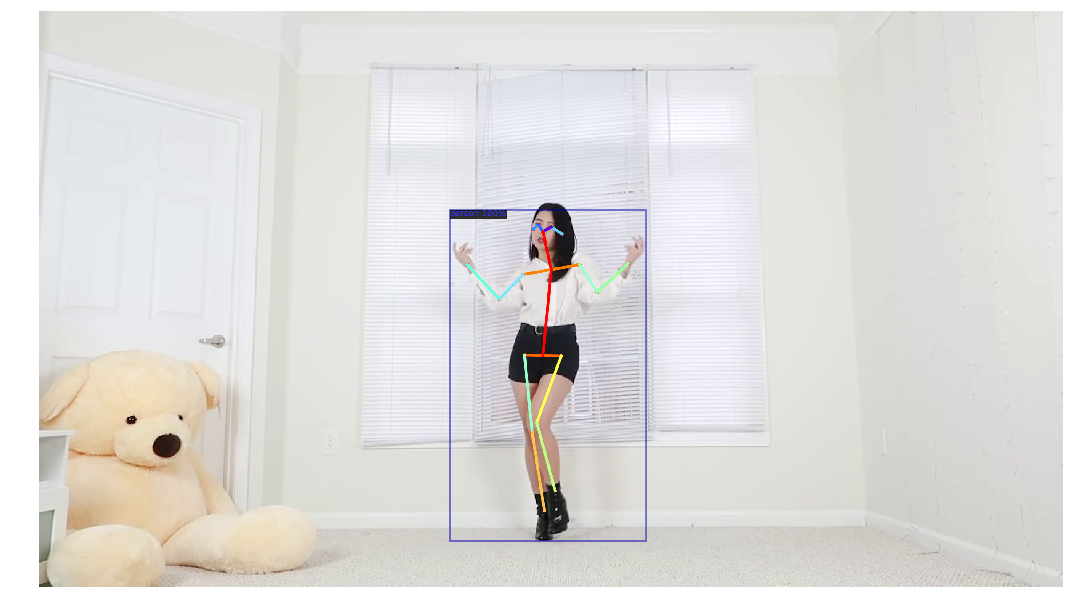

In [30]:
# Steps for basic COCO keypoint detection
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_X_101_32x8d_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)

v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
out_image = out.get_image()
just_image(out_image)

In [31]:
# Build project-specific config
cfg = get_cfg()
densepose.add_densepose_config(cfg)
cfg.merge_from_file("configs/densepose_rcnn_R_50_FPN_s1x.yaml")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = "https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl"
predictor = DefaultPredictor(cfg)

visualizers = [DensePoseResultsContourVisualizer(cfg=cfg), DensePoseResultsUVisualizer(cfg=cfg), ScoredBoundingBoxVisualizer(cfg=cfg)]
extractors = [create_extractor(visualizer) for visualizer in visualizers]
extractor = CompoundExtractor(extractors)
visualizer = CompoundVisualizer(visualizers)

In [32]:
im = cv2.cvtColor(im, cv2.COLOR_RGBA2BGR) # Detector expects BGR format
outputs = predictor(im)["instances"]
data = extractor(outputs)

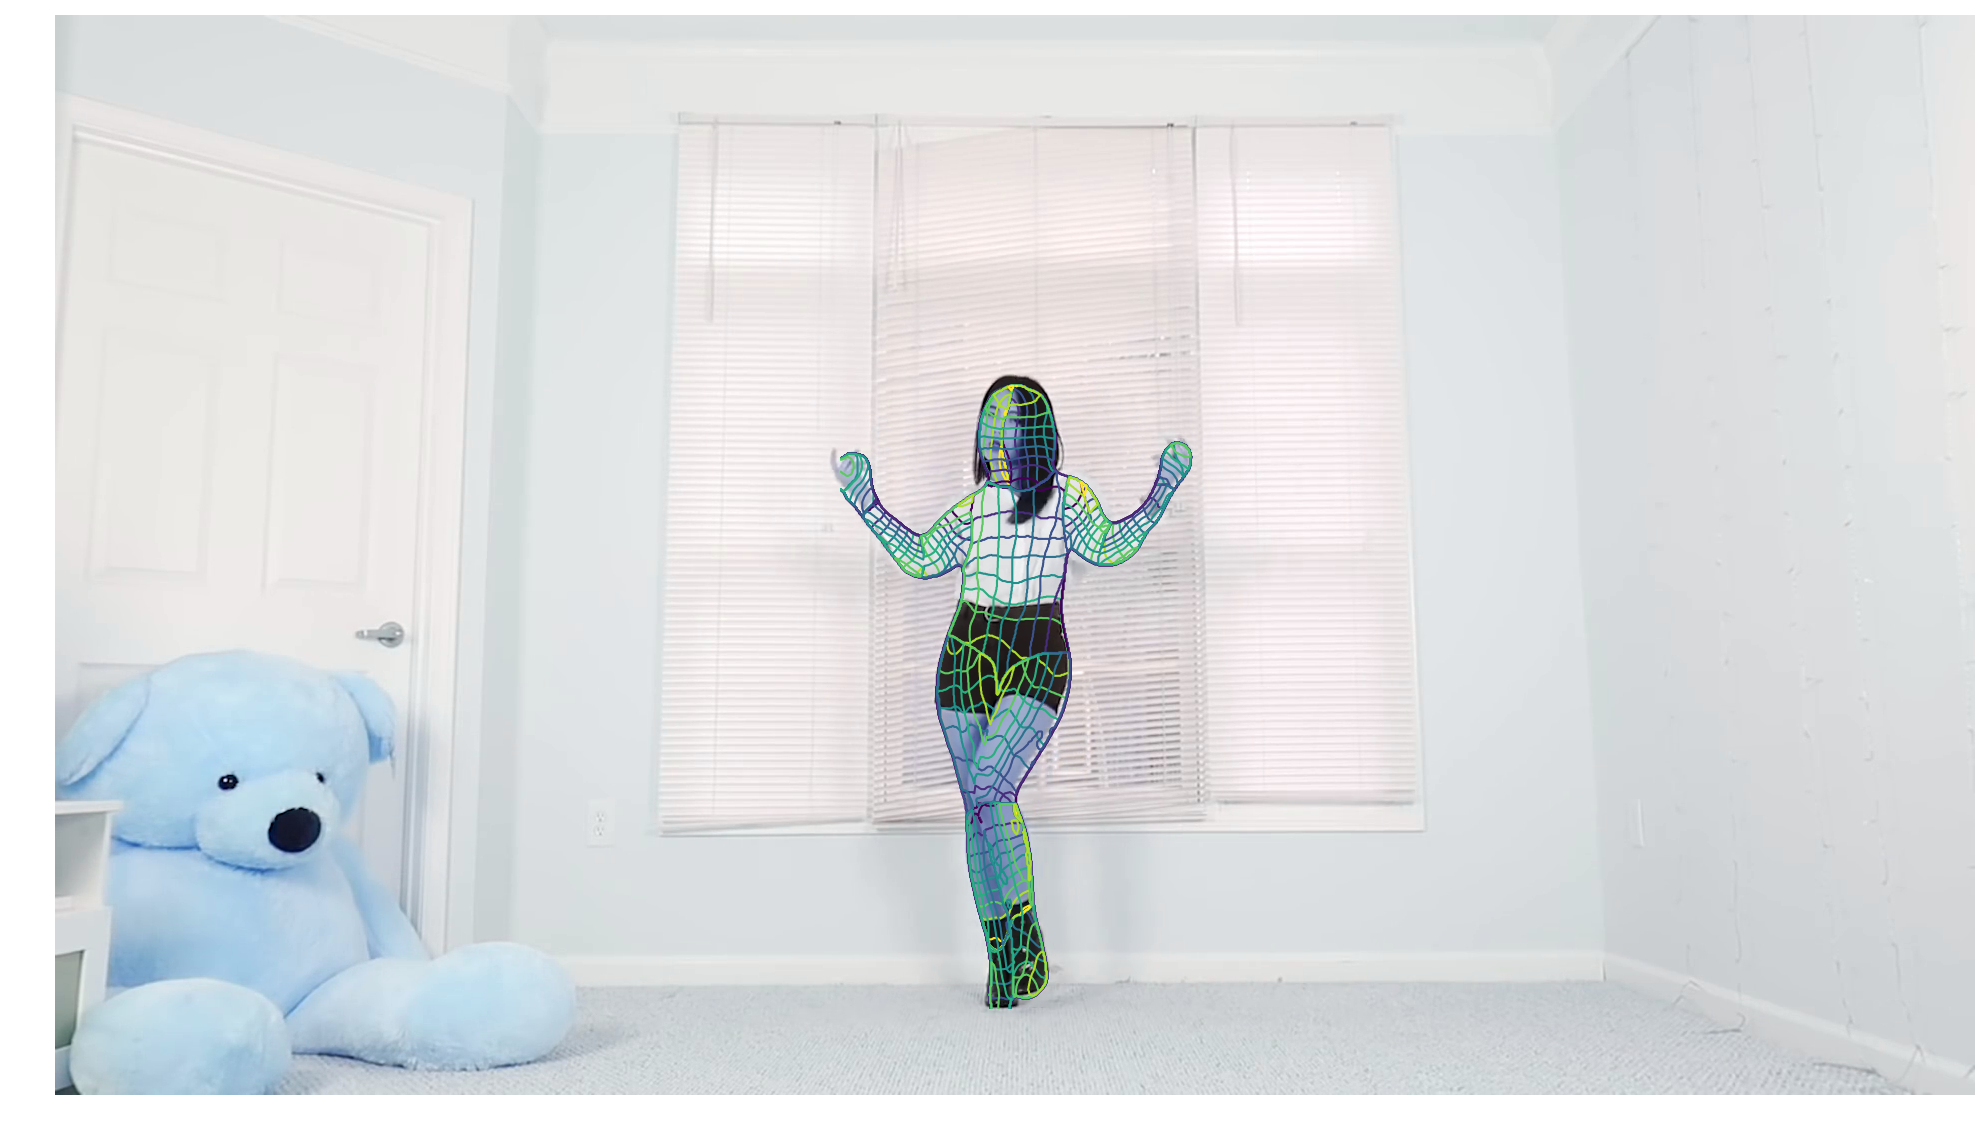

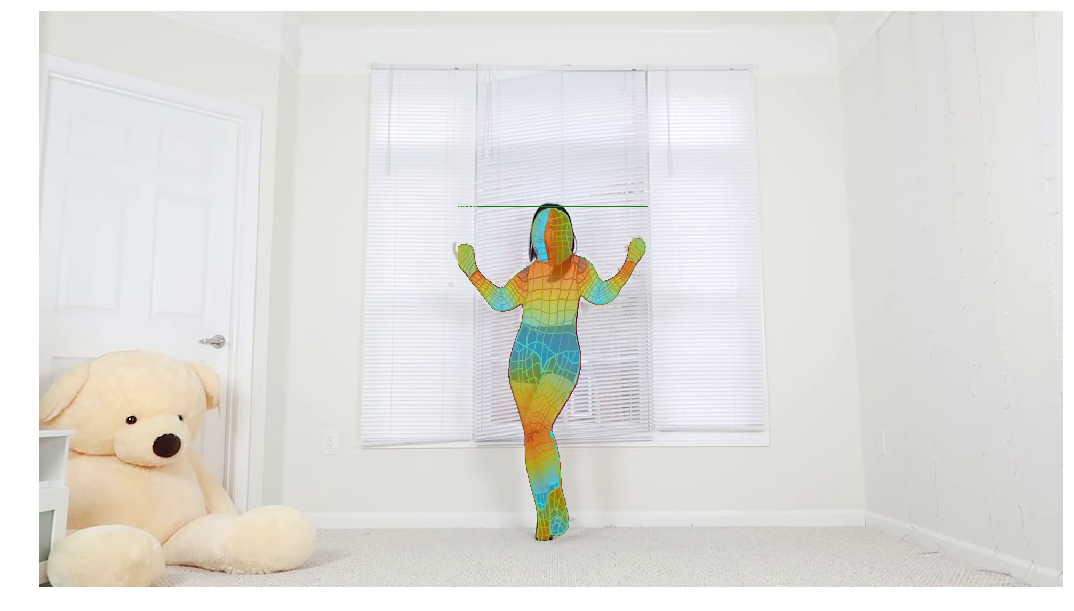

In [33]:
image_vis = visualizer.visualize(im, data)
just_image(image_vis)

In [7]:
#export
import torch

# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

import densepose

from densepose.vis.extractor import (
    CompoundExtractor,
    DensePoseOutputsExtractor,
    DensePoseResultExtractor,
    create_extractor,
)
from densepose.vis.base import CompoundVisualizer
from densepose.vis.bounding_box import ScoredBoundingBoxVisualizer
from densepose.vis.densepose_outputs_vertex import (
    DensePoseOutputsTextureVisualizer,
    DensePoseOutputsVertexVisualizer,
    get_texture_atlases,
)
from densepose.vis.densepose_results import (
    DensePoseResultsContourVisualizer,
    DensePoseResultsFineSegmentationVisualizer,
    DensePoseResultsUVisualizer,
    DensePoseResultsVVisualizer,
)
from densepose.vis.densepose_results_textures import (
    DensePoseResultsVisualizerWithTexture,
    get_texture_atlas,
)

import PIL
import cv2
import os

import matplotlib.pyplot as plt

def just_image(ima):
    w,h = plt.figaspect(ima)
    fig, ax = plt.subplots(figsize=(w*2, h*2), dpi=72)
    fig.subplots_adjust(0,0,1,1)
    plt.axis('off')
    ax.imshow(ima)
    plt.show()
    

class Detector:
    """Given a still image (or video frame), finds poses.
    
    Attributes:  
    """
    
    def __init__(self):
        
        try:
            self.device = torch.device('cuda')  # if cuda is available
        except:
            self.device = torch.device('cpu')
        
        cfg = get_cfg()
        densepose.add_densepose_config(cfg)
        cfg.merge_from_file("configs/densepose_rcnn_R_50_FPN_s1x.yaml")
        cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
        cfg.MODEL.WEIGHTS = "https://dl.fbaipublicfiles.com/densepose/densepose_rcnn_R_50_FPN_s1x/165712039/model_final_162be9.pkl"
        self.predictor = DefaultPredictor(cfg)

        visualizers = [DensePoseResultsContourVisualizer(cfg=cfg), DensePoseResultsUVisualizer(cfg=cfg), ScoredBoundingBoxVisualizer(cfg=cfg)]
        extractors = [create_extractor(visualizer) for visualizer in visualizers]
        self.extractor = CompoundExtractor(extractors)
        self.visualizer = CompoundVisualizer(visualizers)

#     def __detect_one_or_more_images__(self, batch):
#         data = openpifpaf.datasets.PilImageList(batch, preprocess=self.__preprocess__)
#         batch_size = len(batch)

#         loader = torch.utils.data.DataLoader(
#             data, batch_size=batch_size, pin_memory=True, 
#             collate_fn=openpifpaf.datasets.collate_images_anns_meta)

#         for images_batch, _, __ in loader:
#             detections = self.processor.batch(self.net, images_batch, device=self.device)[0]
  
#         return detections

    def detect_image_array(self, image_array):
        im = cv2.cvtColor(image_array, cv2.COLOR_RGBA2BGR) # Detector expects BGR format
        outputs = self.predictor(im)["instances"]
        data = self.extractor(outputs)
        return data
    
    def detect_image_file(self, image_path):
        """ Applies the pose detection model to a single image file. Returns detections. """
        im = cv2.imread("sample_data/sample1.png")
        return self.detect_image_array(im)
    
    def draw_detections(self, image_array, data):
        image_vis = self.visualizer.visualize(image_array, data)
        return image_vis
    
    def detect_video(self, video_file, start_seconds=0.0, end_seconds=0.0, max_frames=0, seconds_to_skip=0.0, images_too=False, write_images=False, folder_name='video_folder'):
        """ Given a video file, extracts video frames as images at `seconds_to_skip` intervals,
            from `start_seconds` to `end_seconds`, and runs `__detect_one_or_more_images__()` on each.
            Returns a list of frame pose data items, which are dictionaries with the following elements:
            { 'frame_id': <the frame's position in this list (not in the entire video, if seconds_to_skip != 0)>, 
              'time': <the frame's timecode within the excerpt (not within the full video, if start_seconds != 0)>,
              'figures': [<OpenPifPaf pose detection objects> for all figures detected in the frame]
              <OPTIONAL> 'image': <a PIL image object for the frame>
            }
            `write_images`, if true, causes the extracted frame images to be written to a folder
            specified by `folder_name`, with the naming scheme `image00001.png`
        """
        
        cap = cv2.VideoCapture(video_file)

        total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        print('total frames in video:',total_frames)

        video_framerate = cap.get(cv2.CAP_PROP_FPS)
        print('video FPS:',video_framerate)
        frame_duration = 1 / float(video_framerate)

        frame_count = 0.0
        frames_processed = 0
        timecode = 0.0
        skip_until = start_seconds

        pose_output = []

        if write_images:
            if not os.path.isdir(folder_name):
                os.mkdir(folder_name)
            for filename in os.listdir(folder_name):
                file_path = os.path.join(folder_name, filename)
                if os.path.isfile(file_path) or os.path.islink(file_path):
                    os.unlink(file_path)

        while cap.isOpened() and (frame_count < total_frames):
            ret_val, im = cap.read()

            timecode = frame_count * frame_duration
            frame_count += 1

            if (end_seconds and timecode > end_seconds) or (max_frames and frames_processed >= max_frames):
                return pose_output

            if timecode < start_seconds:
                continue

            if im is None:
                # Might want to retry here
                # print("Missed a frame, continuing...")
                # For now, we'll count a missed frame as a processed frame
                continue

            if seconds_to_skip and timecode < skip_until:
                continue
            else:
                skip_until += seconds_to_skip

            im_height, im_width, im_channels = im.shape

            frame_id = int(round(cap.get(1)))

            #pil_image = PIL.Image.fromarray(im)
            #detections = self.__detect_one_or_more_images__([pil_image])
            
            detections = self.detect_image_array(im)

            print("Frame",frame_count,"of",total_frames,round(timecode,2),"figures",len(detections))

            this_frame_data = {'frame_id': frame_count, 'time': timecode, 'figures': detections} #, 'flipped_figures': flipped_detections, 'zeroified_figures': zeroified_detections}
            if images_too:
                this_frame_data['image'] = im
            if write_images:
                if write_images:
                    output_image_array = self.draw_detections(im, this_frame_data['figures'])
                    # Image doesn't necessarily come in as RGB(A)!
                    #rgbim = cv2.cvtColor(output_image_array, cv2.COLOR_BGR2RGBA)
                    pil_image = PIL.Image.fromarray(output_image_array)
                    pil_image.save(os.path.join(folder_name, 'image' + str(int(frames_processed + 1)).zfill(5) + '.png'), 'PNG')

            pose_output.append(this_frame_data)
            frames_processed += 1

        return pose_output

In [8]:
show_doc(Detector.detect_image)
show_doc(Detector.detect_video)

NameError: name 'show_doc' is not defined

In [ ]:
teddy = Detector()
import pickle
pose_output = teddy.detect_video("/srv/choreo/Einstein.mp4", start_seconds=6310, end_seconds=7288, write_images=True, images_too=False)
pickle.dump(pose_output, open("theater_videos/Einstein_Ballet_6310_to_7288.p", "wb"))

total frames in video: 408587
video FPS: 25.0
Frame 157751.0 of 408587 6310.0 figures 3
Frame 157752.0 of 408587 6310.04 figures 3
Frame 157753.0 of 408587 6310.08 figures 3
Frame 157754.0 of 408587 6310.12 figures 3
Frame 157755.0 of 408587 6310.16 figures 3
Frame 157756.0 of 408587 6310.2 figures 3
Frame 157757.0 of 408587 6310.24 figures 3
Frame 157758.0 of 408587 6310.28 figures 3
Frame 157759.0 of 408587 6310.32 figures 3
Frame 157760.0 of 408587 6310.36 figures 3
Frame 157761.0 of 408587 6310.4 figures 3
Frame 157762.0 of 408587 6310.44 figures 3
Frame 157763.0 of 408587 6310.48 figures 3
Frame 157764.0 of 408587 6310.52 figures 3
Frame 157765.0 of 408587 6310.56 figures 3
Frame 157766.0 of 408587 6310.6 figures 3
Frame 157767.0 of 408587 6310.64 figures 3
Frame 157768.0 of 408587 6310.68 figures 3
Frame 157769.0 of 408587 6310.72 figures 3
Frame 157770.0 of 408587 6310.76 figures 3
Frame 157771.0 of 408587 6310.8 figures 3
Frame 157772.0 of 408587 6310.84 figures 3
Frame 157773.

/home/broadwell/.local/lib/python3.7/site-packages/matplotlib/contour.py:960: UserWarning: The following kwargs were not used by contour: 'cfg'
  s)


Frame 157782.0 of 408587 6311.24 figures 3
Frame 157783.0 of 408587 6311.28 figures 3


/home/broadwell/.local/lib/python3.7/site-packages/matplotlib/contour.py:1173: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


Frame 157784.0 of 408587 6311.32 figures 3
Frame 157785.0 of 408587 6311.36 figures 3
Frame 157786.0 of 408587 6311.4 figures 3
Frame 157787.0 of 408587 6311.44 figures 3
Frame 157788.0 of 408587 6311.48 figures 3
Frame 157789.0 of 408587 6311.52 figures 3
Frame 157790.0 of 408587 6311.56 figures 3
Frame 157791.0 of 408587 6311.6 figures 3
Frame 157792.0 of 408587 6311.64 figures 3
Frame 157793.0 of 408587 6311.68 figures 3
Frame 157794.0 of 408587 6311.72 figures 3
Frame 157795.0 of 408587 6311.76 figures 3
Frame 157796.0 of 408587 6311.8 figures 3
Frame 157797.0 of 408587 6311.84 figures 3
Frame 157798.0 of 408587 6311.88 figures 3
Frame 157799.0 of 408587 6311.92 figures 3
Frame 157800.0 of 408587 6311.96 figures 3
Frame 157801.0 of 408587 6312.0 figures 3
Frame 157802.0 of 408587 6312.04 figures 3
Frame 157803.0 of 408587 6312.08 figures 3
Frame 157804.0 of 408587 6312.12 figures 3
Frame 157805.0 of 408587 6312.16 figures 3
Frame 157806.0 of 408587 6312.2 figures 3
Frame 157807.0 o

/home/broadwell/.local/lib/python3.7/site-packages/matplotlib/pyplot.py:537: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Frame 157821.0 of 408587 6312.8 figures 3
Frame 157822.0 of 408587 6312.84 figures 3
Frame 157823.0 of 408587 6312.88 figures 3
Frame 157824.0 of 408587 6312.92 figures 3
Frame 157825.0 of 408587 6312.96 figures 3
Frame 157826.0 of 408587 6313.0 figures 3
Frame 157827.0 of 408587 6313.04 figures 3
Frame 157828.0 of 408587 6313.08 figures 3
Frame 157829.0 of 408587 6313.12 figures 3
Frame 157830.0 of 408587 6313.16 figures 3
Frame 157831.0 of 408587 6313.2 figures 3
Frame 157832.0 of 408587 6313.24 figures 3
Frame 157833.0 of 408587 6313.28 figures 3
Frame 157834.0 of 408587 6313.32 figures 3
Frame 157835.0 of 408587 6313.36 figures 3
Frame 157836.0 of 408587 6313.4 figures 3
Frame 157837.0 of 408587 6313.44 figures 3
Frame 157838.0 of 408587 6313.48 figures 3
Frame 157839.0 of 408587 6313.52 figures 3
Frame 157840.0 of 408587 6313.56 figures 3
Frame 157841.0 of 408587 6313.6 figures 3
Frame 157842.0 of 408587 6313.64 figures 3
Frame 157843.0 of 408587 6313.68 figures 3
Frame 157844.0 o

Frame 158013.0 of 408587 6320.48 figures 3
Frame 158014.0 of 408587 6320.52 figures 3
Frame 158015.0 of 408587 6320.56 figures 3
Frame 158016.0 of 408587 6320.6 figures 3
Frame 158017.0 of 408587 6320.64 figures 3
Frame 158018.0 of 408587 6320.68 figures 3
Frame 158019.0 of 408587 6320.72 figures 3
Frame 158020.0 of 408587 6320.76 figures 3
Frame 158021.0 of 408587 6320.8 figures 3
Frame 158022.0 of 408587 6320.84 figures 3
Frame 158023.0 of 408587 6320.88 figures 3
Frame 158024.0 of 408587 6320.92 figures 3
Frame 158025.0 of 408587 6320.96 figures 3
Frame 158026.0 of 408587 6321.0 figures 3
Frame 158027.0 of 408587 6321.04 figures 3
Frame 158028.0 of 408587 6321.08 figures 3
Frame 158029.0 of 408587 6321.12 figures 3
Frame 158030.0 of 408587 6321.16 figures 3
Frame 158031.0 of 408587 6321.2 figures 3
Frame 158032.0 of 408587 6321.24 figures 3
Frame 158033.0 of 408587 6321.28 figures 3
Frame 158034.0 of 408587 6321.32 figures 3
Frame 158035.0 of 408587 6321.36 figures 3
Frame 158036.0 

Frame 158206.0 of 408587 6328.2 figures 3
Frame 158207.0 of 408587 6328.24 figures 3
Frame 158208.0 of 408587 6328.28 figures 3
Frame 158209.0 of 408587 6328.32 figures 3
Frame 158210.0 of 408587 6328.36 figures 3
Frame 158211.0 of 408587 6328.4 figures 3
Frame 158212.0 of 408587 6328.44 figures 3
Frame 158213.0 of 408587 6328.48 figures 3
Frame 158214.0 of 408587 6328.52 figures 3
Frame 158215.0 of 408587 6328.56 figures 3
Frame 158216.0 of 408587 6328.6 figures 3
Frame 158217.0 of 408587 6328.64 figures 3
Frame 158218.0 of 408587 6328.68 figures 3
Frame 158219.0 of 408587 6328.72 figures 3
Frame 158220.0 of 408587 6328.76 figures 3
Frame 158221.0 of 408587 6328.8 figures 3
Frame 158222.0 of 408587 6328.84 figures 3
Frame 158223.0 of 408587 6328.88 figures 3
Frame 158224.0 of 408587 6328.92 figures 3
Frame 158225.0 of 408587 6328.96 figures 3
Frame 158226.0 of 408587 6329.0 figures 3
Frame 158227.0 of 408587 6329.04 figures 3
Frame 158228.0 of 408587 6329.08 figures 3
Frame 158229.0 o

In [ ]:
try:
    teddy = Detector()
    detections = teddy.detect_image_file('sample_data/sample1.png')
    print(detections[0])
except:
    print("Unable to instantiate a detector on your system. Do you have PyTorch with CUDA enabled?")